In [1]:
import backtrader as bt
import pandas as pd
import numpy as np
import random
import pytz
import time
import os
from xbbg import blp
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact, Dropdown, HBox, VBox, Button, Output, Text, widgets
import sympy as sp
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from IPython import get_ipython
import matplotlib.dates as mdates
from pydataquery import DataQuery
import re
import statsmodels.api as sm
from scipy.optimize import minimize
import scipy.stats as stats
import itertools
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
import yfinance as yf
import csv
import uuid
from concurrent.futures import ThreadPoolExecutor
import warnings
from multiprocess import Pool
import time
warnings.filterwarnings('ignore')

In [2]:
cdx_mult = 1

cdx = "CDX HY CDSI GEN 5Y SPRD CORP"
bond_etf = "HYG US EQUITY"
cdx_name = "CDX HY 5Y"
rates_etf = "USGG5YR INDEX"
rates_etf_name = "US 5Y"

# cdx = "CDX IG CDSI GEN 5Y SPRD CORP"
# bond_etf = "VCIT US EQUITY"
# cdx_name = "CDX IG 5Y"
# rates_etf = "USGG5YR INDEX"
# rates_etf_name = "US 5Y"

# cdx = "CDX EM CDSI GEN 5Y SPRD CORP"
# bond_etf = "EMB US EQUITY"
# cdx_name = "CDX EM 5Y"
# rates_etf = "USGG7YR INDEX"
# rates_etf_name = "US 7Y"

# cdx = "CDX IG CDSI GEN 10Y SPRD CORP"
# bond_etf = "LQD US EQUITY"
# cdx_name = "CDX IG 10Y"
# rates_etf = "USGG10YR INDEX"
# rates_etf_name = "US 10Y"

In [3]:
bond_etf_name = bond_etf.split(" ")[0]
all_basis_data = pd.read_excel("All Basis Data.xlsx",index_col=0, parse_dates=True)
px = all_basis_data[[cdx_name,bond_etf_name,rates_etf_name]].ffill().copy()

px_hist = blp.bdh(tickers=[cdx, bond_etf, rates_etf], flds="PX_LAST",start_date="2020-1-1")
daily = px_hist.dropna().copy()
daily.columns = [cdx_name, bond_etf_name,rates_etf_name]
daily.index.name = "Date"
daily = daily.reset_index()

dvd_hist = blp.bds(bond_etf, 'DVD_HIST_ALL', DVD_START_DT='20210101', DVD_END_DT='20251201' )
dvd = dvd_hist[["ex_date"]].reset_index().copy()
dvd.columns = ["Div","Date"]

comb = pd.merge(left=daily, right=dvd, on="Date", how="outer").set_index("Date").sort_index().copy()
comb1 = comb.copy()

dvd_dict = {}
dv = list(comb[f"Div"].dropna().index)

period_list = ['-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', '-2', '-1', '+0', '+1', '+2', '+3', '+4', '+5', '+6', '+7', '+8', '+9', '+10']
# period_list = ['-20', '-19', '-18', '-17', '-16', '-15', '-14', '-13', '-12', '-11', '-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', '-2', '-1', '+0']
shifted_indices = {}

for p in period_list:
    col_name = f"Div{p}"
    comb[col_name] = comb["Div"].shift(eval(p))
    key = f"p{p.replace('-','minus').replace('+','plus')}"
    shifted_indices[key] = list(comb[col_name].dropna().index)

dvd_dict = {}
for i, dv_item in enumerate(dv):
    dvd_dict[str(dv_item)] = [
        str(shifted_indices[f"p{p.replace('-','minus').replace('+','plus')}"][i])
        for p in period_list
        if i < len(shifted_indices[f"p{p.replace('-','minus').replace('+','plus')}"])
    ]

all_dates_list = []
for key, val in dvd_dict.items():
    all_dates_list += val

px = px[px.index.normalize().isin(all_dates_list)]
# px.to_excel(f"{cdx_name}_10days.xlsx")
# px.to_excel(f"{cdx_name}_20days.xlsx")

In [4]:
add_dvd_dict = {}
dv_amt = dict(zip([str(item) for item in dvd_hist["ex_date"]],dvd_hist["dividend_amount"]))

for key, val in dv_amt.items():
    l1 = [item for item in list(dvd_dict[key]) if pd.to_datetime(item) >= pd.to_datetime(key)]
    for item_l1 in l1:
        add_dvd_dict[item_l1] = val

In [6]:
new_px = None
all_dates = sorted(set(px.index.date))
for item_date in all_dates:
    temp_df = px[px.index.date==item_date].copy()
    # display(temp_df.tail())
    if str(item_date) in add_dvd_dict.keys():
        # display(add_dvd_dict[str(item_date)])
        temp_df[["HYG"]] += add_dvd_dict[str(item_date)]
    # display(temp_df.tail())
    new_px = pd.concat([new_px, temp_df])
# new_px.to_excel(f"{cdx_name} Div added back px.xlsx")

In [29]:
cdx_name

'CDX HY 5Y'

In [7]:
px = pd.read_excel(f"{cdx_name} Div added back px.xlsx",index_col=0,parse_dates=True)
# px = pd.read_excel(f"{cdx_name}_Raw.xlsx",index_col=0,parse_dates=True)
# px = pd.read_excel(f"{cdx_name}_10days.xlsx",index_col=0,parse_dates=True)
# px = pd.read_excel(f"{cdx_name}_20days.xlsx",index_col=0,parse_dates=True)
px["Basis"] = cdx_mult * px[cdx_name] - 100*(px[f'{bond_etf_name} Yld'] - px[rates_etf_name])
px = px[["Basis"]]

all_t = None
for key, val in dvd_dict.items():
    try:
        t_minus10 = px[px.index.date == pd.to_datetime(val[0]).date()]
        t_minus10.index = ["T-10 " + str(item).split(" ")[1] for item in t_minus10.index]
        
        t_minus9 = px[px.index.date == pd.to_datetime(val[1]).date()]
        t_minus9.index = ["T-9 " + str(item).split(" ")[1] for item in t_minus9.index]
        
        t_minus8 = px[px.index.date == pd.to_datetime(val[2]).date()]
        t_minus8.index = ["T-8 " + str(item).split(" ")[1] for item in t_minus8.index]
        
        t_minus7 = px[px.index.date == pd.to_datetime(val[3]).date()]
        t_minus7.index = ["T-7 " + str(item).split(" ")[1] for item in t_minus7.index]
        
        t_minus6 = px[px.index.date == pd.to_datetime(val[4]).date()]
        t_minus6.index = ["T-6 " + str(item).split(" ")[1] for item in t_minus6.index]
        
        t_minus5 = px[px.index.date == pd.to_datetime(val[5]).date()]
        t_minus5.index = ["T-5 " + str(item).split(" ")[1] for item in t_minus5.index]
        
        t_minus4 = px[px.index.date == pd.to_datetime(val[6]).date()]
        t_minus4.index = ["T-4 " + str(item).split(" ")[1] for item in t_minus4.index]
        
        t_minus3 = px[px.index.date == pd.to_datetime(val[7]).date()]
        t_minus3.index = ["T-3 " + str(item).split(" ")[1] for item in t_minus3.index]
        
        t_minus2 = px[px.index.date == pd.to_datetime(val[8]).date()]
        t_minus2.index = ["T-2 " + str(item).split(" ")[1] for item in t_minus2.index]
        
        t_minus1 = px[px.index.date == pd.to_datetime(val[9]).date()]
        t_minus1.index = ["T-1 " + str(item).split(" ")[1] for item in t_minus1.index]
        
        t0 = px[px.index.date == pd.to_datetime(val[10]).date()]
        t0.index = ["T+0 " + str(item).split(" ")[1] for item in t0.index]
        
        t_plus1 = px[px.index.date == pd.to_datetime(val[11]).date()]
        t_plus1.index = ["T+1 " + str(item).split(" ")[1] for item in t_plus1.index]
        
        t_plus2 = px[px.index.date == pd.to_datetime(val[12]).date()]
        t_plus2.index = ["T+2 " + str(item).split(" ")[1] for item in t_plus2.index]
        
        t_plus3 = px[px.index.date == pd.to_datetime(val[13]).date()]
        t_plus3.index = ["T+3 " + str(item).split(" ")[1] for item in t_plus3.index]
        
        t_plus4 = px[px.index.date == pd.to_datetime(val[14]).date()]
        t_plus4.index = ["T+4 " + str(item).split(" ")[1] for item in t_plus4.index]
        
        t_plus5 = px[px.index.date == pd.to_datetime(val[15]).date()]
        t_plus5.index = ["T+5 " + str(item).split(" ")[1] for item in t_plus5.index]
        
        t_plus6 = px[px.index.date == pd.to_datetime(val[16]).date()]
        t_plus6.index = ["T+6 " + str(item).split(" ")[1] for item in t_plus6.index]
        
        t_plus7 = px[px.index.date == pd.to_datetime(val[17]).date()]
        t_plus7.index = ["T+7 " + str(item).split(" ")[1] for item in t_plus7.index]
        
        t_plus8 = px[px.index.date == pd.to_datetime(val[18]).date()]
        t_plus8.index = ["T+8 " + str(item).split(" ")[1] for item in t_plus8.index]
        
        t_plus9 = px[px.index.date == pd.to_datetime(val[19]).date()]
        t_plus9.index = ["T+9 " + str(item).split(" ")[1] for item in t_plus9.index]
        
        t_plus10 = px[px.index.date == pd.to_datetime(val[20]).date()]
        t_plus10.index = ["T+10 " + str(item).split(" ")[1] for item in t_plus10.index]
        
        t = pd.concat([
            t_minus10, t_minus9, t_minus8, t_minus7, t_minus6, t_minus5, t_minus4, t_minus3, t_minus2, t_minus1,
            t0,
            t_plus1, t_plus2, t_plus3, t_plus4, t_plus5, t_plus6, t_plus7, t_plus8, t_plus9, t_plus10])

        # t_minus20 = px[px.index.date == pd.to_datetime(val[0]).date()].copy()
        # t_minus20.index = ["T-20 " + str(item).split(" ")[1] for item in t_minus20.index]
        
        # t_minus19 = px[px.index.date == pd.to_datetime(val[1]).date()].copy()
        # t_minus19.index = ["T-19 " + str(item).split(" ")[1] for item in t_minus19.index]
        
        # t_minus18 = px[px.index.date == pd.to_datetime(val[2]).date()].copy()
        # t_minus18.index = ["T-18 " + str(item).split(" ")[1] for item in t_minus18.index]
        
        # t_minus17 = px[px.index.date == pd.to_datetime(val[3]).date()].copy()
        # t_minus17.index = ["T-17 " + str(item).split(" ")[1] for item in t_minus17.index]
        
        # t_minus16 = px[px.index.date == pd.to_datetime(val[4]).date()].copy()
        # t_minus16.index = ["T-16 " + str(item).split(" ")[1] for item in t_minus16.index]
        
        # t_minus15 = px[px.index.date == pd.to_datetime(val[5]).date()].copy()
        # t_minus15.index = ["T-15 " + str(item).split(" ")[1] for item in t_minus15.index]
        
        # t_minus14 = px[px.index.date == pd.to_datetime(val[6]).date()].copy()
        # t_minus14.index = ["T-14 " + str(item).split(" ")[1] for item in t_minus14.index]
        
        # t_minus13 = px[px.index.date == pd.to_datetime(val[7]).date()].copy()
        # t_minus13.index = ["T-13 " + str(item).split(" ")[1] for item in t_minus13.index]
        
        # t_minus12 = px[px.index.date == pd.to_datetime(val[8]).date()].copy()
        # t_minus12.index = ["T-12 " + str(item).split(" ")[1] for item in t_minus12.index]
        
        # t_minus11 = px[px.index.date == pd.to_datetime(val[9]).date()].copy()
        # t_minus11.index = ["T-11 " + str(item).split(" ")[1] for item in t_minus11.index]
        
        # t_minus10 = px[px.index.date == pd.to_datetime(val[10]).date()].copy()
        # t_minus10.index = ["T-10 " + str(item).split(" ")[1] for item in t_minus10.index]
        
        # t_minus9 = px[px.index.date == pd.to_datetime(val[11]).date()].copy()
        # t_minus9.index = ["T-9 " + str(item).split(" ")[1] for item in t_minus9.index]
        
        # t_minus8 = px[px.index.date == pd.to_datetime(val[12]).date()].copy()
        # t_minus8.index = ["T-8 " + str(item).split(" ")[1] for item in t_minus8.index]
        
        # t_minus7 = px[px.index.date == pd.to_datetime(val[13]).date()].copy()
        # t_minus7.index = ["T-7 " + str(item).split(" ")[1] for item in t_minus7.index]
        
        # t_minus6 = px[px.index.date == pd.to_datetime(val[14]).date()].copy()
        # t_minus6.index = ["T-6 " + str(item).split(" ")[1] for item in t_minus6.index]
        
        # t_minus5 = px[px.index.date == pd.to_datetime(val[15]).date()].copy()
        # t_minus5.index = ["T-5 " + str(item).split(" ")[1] for item in t_minus5.index]
        
        # t_minus4 = px[px.index.date == pd.to_datetime(val[16]).date()].copy()
        # t_minus4.index = ["T-4 " + str(item).split(" ")[1] for item in t_minus4.index]
        
        # t_minus3 = px[px.index.date == pd.to_datetime(val[17]).date()].copy()
        # t_minus3.index = ["T-3 " + str(item).split(" ")[1] for item in t_minus3.index]
        
        # t_minus2 = px[px.index.date == pd.to_datetime(val[18]).date()].copy()
        # t_minus2.index = ["T-2 " + str(item).split(" ")[1] for item in t_minus2.index]
        
        # t_minus1 = px[px.index.date == pd.to_datetime(val[19]).date()].copy()
        # t_minus1.index = ["T-1 " + str(item).split(" ")[1] for item in t_minus1.index]
        
        # t0 = px[px.index.date == pd.to_datetime(val[20]).date()].copy()
        # t0.index = ["T+0 " + str(item).split(" ")[1] for item in t0.index]
        
        # t = pd.concat([
        #     t_minus20, t_minus19, t_minus18, t_minus17, t_minus16, t_minus15, t_minus14, t_minus13, t_minus12, t_minus11,
        #     t_minus10, t_minus9, t_minus8, t_minus7, t_minus6, t_minus5, t_minus4, t_minus3, t_minus2, t_minus1, t0
        # ])


        t.columns = [key]
        all_t = pd.concat([all_t, t],axis=1)
    except:
        h=1
all_t = all_t.dropna(how="all",axis=1).copy()

ty = all_t.copy()
ty["Key"] = [item.split(" ")[0] for item in ty.index]
ty["Key2"] = [pd.to_datetime(item.split(" ")[1]).time() for item in ty.index]
order = ["T"+item for item in period_list]#["T-3", "T-2", "T-1", "T+0", "T+1", "T+2", "T+3"]
order_map = {k: i for i, k in enumerate(order)}
ty = ty.sort_values(by=["Key", "Key2"], key=lambda col: col.map(order_map) if col.name == "Key" else col).drop(["Key2"],axis=1)

all_y = None
for item in order:
    x = ty[ty["Key"]==item].drop(["Key"],axis=1).iloc[:,-12:]
    x = x - x.iloc[0]
    
    y = ty[ty["Key"]==item].drop(["Key"],axis=1)#.iloc[:,-12:]
    y = (y - y.iloc[0]).iloc[[-1]].T
    all_y = pd.concat([all_y, y],axis=1)
    # break
    # x.plot(figsize=(12,4))
    # plt.axhline(0, color="black",linewidth=3)
    # plt.title(f"{cdx_name} Basis move on {item}")
    # plt.legend(loc="lower left")
    # plt.show()
all_data = pd.DataFrame(all_y.mean())
all_data.index.name = cdx_name + " Basis"
all_data.columns = ["Mean"]
all_data["Median"] = all_y.median()
all_data["All Data Points"] = [np.nan] * len(all_data)
all_data["Positive Basis Move Data Points"] = [np.nan] * len(all_data)
all_data["Avg. Positive Basis Move"] = [np.nan] * len(all_data)
all_data["Median Positive Basis Move"] = [np.nan] * len(all_data)
all_data["Negative Basis Move Data Points"] = [np.nan] * len(all_data)
all_data["Median Negative Basis Move"] = [np.nan] * len(all_data)

for col in all_y.columns:
# col = all_y.columns[0]
    z = list(all_y[col].dropna())
    pos = [item for item in z if item>0]
    neg = [item for item in z if item<0]
    
    all_data.loc[col, "All Data Points"] = len(z)
    all_data.loc[col, "Positive Basis Move Data Points"] = len(pos)
    all_data.loc[col, "Avg. Positive Basis Move"] = np.mean(pos)
    all_data.loc[col, "Median Positive Basis Move"] = np.median(pos)
    
    all_data.loc[col, "Negative Basis Move Data Points"] = len(neg)
    all_data.loc[col, "Avg. Negative Basis Move"] = np.mean(neg)
    all_data.loc[col, "Median Negative Basis Move"] = np.median(neg)
    
all_data["% Positive Basis Move"] = all_data["Positive Basis Move Data Points"]*100/all_data["All Data Points"]
all_data["% Negative Basis Move"] = all_data["Negative Basis Move Data Points"]*100/all_data["All Data Points"]
all_data = all_data[["Mean","Median","% Positive Basis Move","Avg. Positive Basis Move","Median Positive Basis Move",\
    "% Negative Basis Move","Avg. Negative Basis Move","Median Negative Basis Move"]]
all_data = round(all_data,2)
all_data

,Mean,Median,% Positive Basis Move,Avg. Positive Basis Move,Median Positive Basis Move,% Negative Basis Move,Avg. Negative Basis Move,Median Negative Basis Move
CDX HY 5Y Basis,,,,,,,,
T-10 15:55:00,0.04,1.06,57.41,3.76,2.73,42.59,-4.97,-3.91
T-9 15:55:00,0.43,0.63,51.85,4.43,2.88,48.15,-3.87,-2.91
T-8 15:55:00,0.76,1.03,57.41,3.96,2.92,42.59,-3.55,-1.98
T-7 15:55:00,1.62,1.57,59.26,4.78,2.96,40.74,-2.98,-2.14
T-6 15:55:00,-0.30,0.59,53.70,3.01,2.14,46.30,-4.15,-3.32
T-5 15:55:00,1.33,1.44,60.38,4.76,3.90,39.62,-3.88,-2.81
T-4 15:55:00,0.04,-0.18,47.17,4.34,2.83,52.83,-3.81,-2.00
T-3 15:55:00,0.80,0.57,55.56,5.56,2.66,44.44,-5.15,-3.47
T-2 15:55:00,1.04,1.62,60.00,4.36,3.18,40.00,-3.95,-2.97


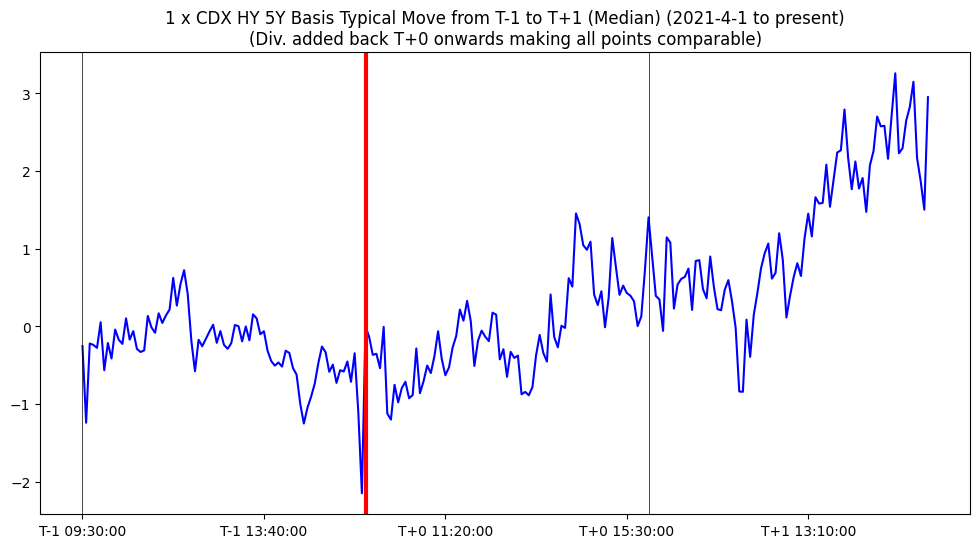

In [31]:
df_plot = ty[ty["Key"].isin(["T-1","T+0","T+1"])].copy()
# df_plot = ty.copy()
na = df_plot.isna().sum()
df_plot = df_plot.drop(list(na[na!=0].index)+["Key"],axis=1)
df_plot = df_plot - df_plot.loc["T+0 09:30:00"]

# s = df_plot.mean(axis=1)
s = df_plot.median(axis=1)
ax = s.plot(figsize=(12,6),color="blue")

# time_labels = [item + " 09:30:00" for item in order]
time_labels = ["T-1 09:30:00", "T+0 09:30:00", "T+1 09:30:00"]

for label in time_labels:
    xpos = s.index.get_loc(label)
    ax.axvline(x=xpos, color='red' if label == "T+0 09:30:00" else 'black', label=label, linewidth = 3 if label == "T+0 09:30:00" else 0.5)
    
plt.title(f"{cdx_mult} x {cdx_name} Basis Typical Move from T-1 to T+1 (Median) (2021-4-1 to present)\n(Div. added back T+0 onwards making all points comparable)")
# plt.legend()
plt.show()

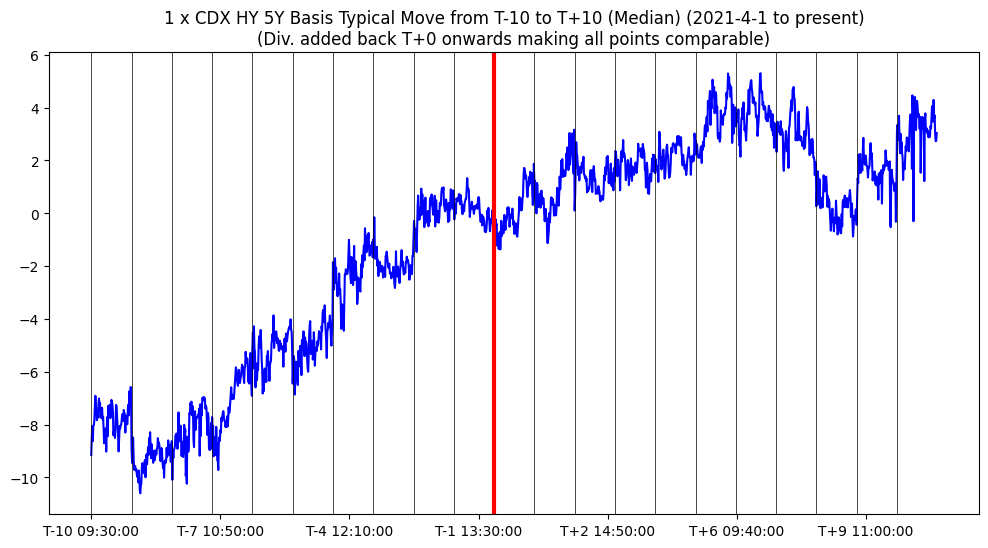

In [32]:
# df_plot = ty[ty["Key"].isin(["T-1","T+0","T+1"])].copy()
df_plot = ty.copy()
na = df_plot.isna().sum()
df_plot = df_plot.drop(list(na[na!=0].index)+["Key"],axis=1)
df_plot = df_plot - df_plot.loc["T+0 09:30:00"]

s = df_plot.median(axis=1)
ax = s.plot(figsize=(12,6),color="blue")

time_labels = [item + " 09:30:00" for item in order]
# time_labels = ["T-1 09:30:00", "T+0 09:30:00", "T+1 09:30:00"]

for label in time_labels:
    xpos = s.index.get_loc(label)
    ax.axvline(x=xpos, color='red' if label == "T+0 09:30:00" else 'black', label=label, linewidth = 3 if label == "T+0 09:30:00" else 0.5)
    
plt.title(f"{cdx_mult} x {cdx_name} Basis Typical Move from T-10 to T+10 (Median) (2021-4-1 to present)\n(Div. added back T+0 onwards making all points comparable)")
# plt.legend()
plt.show()

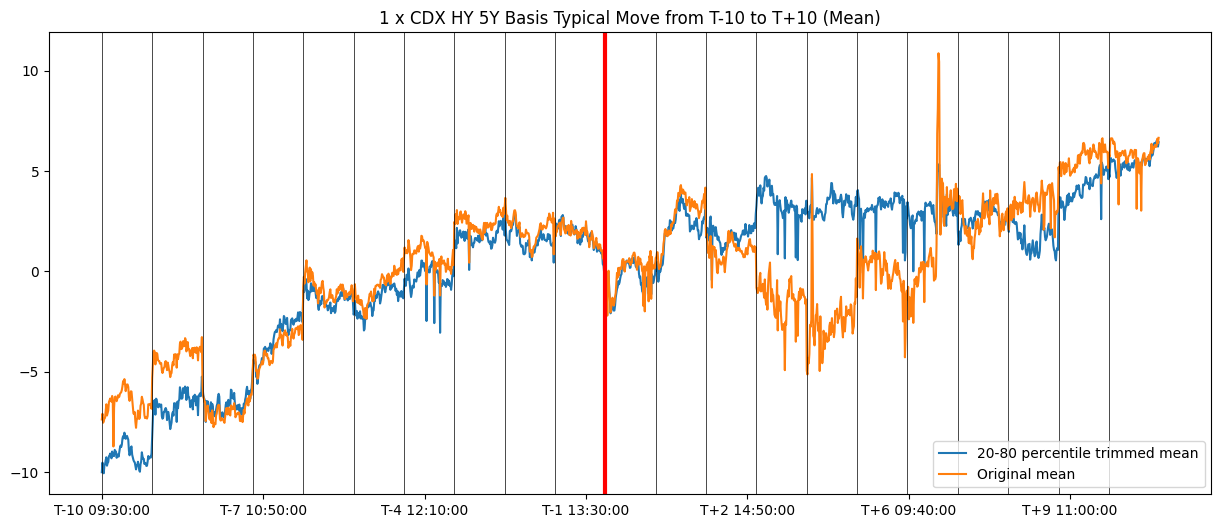

In [10]:
def mask_outliers(row):
    lower = np.percentile(row, 5)
    upper = np.percentile(row, 95)
    return row.where((row >= lower) & (row <= upper), np.nan)

df_plot3_trimmed = df_plot3.apply(mask_outliers, axis=1)
ax=df_plot3_trimmed.mean(axis=1).plot(figsize=(15,6),label="20-80 percentile trimmed mean")
df_plot3.mean(axis=1).plot(ax=ax,label="Original mean")

for label in time_labels:
    xpos = s.index.get_loc(label)
    ax.axvline(x=xpos, color='red' if label == "T+0 09:30:00" else 'black', linewidth = 3 if label == "T+0 09:30:00" else 0.5)
    
plt.title(f"{cdx_mult} x {cdx_name} Basis Typical Move from T-10 to T+10 (Mean)")
plt.legend()
plt.show()

In [11]:
x = df_plot3_trimmed.loc[["T-3 15:55:00","T-2 09:30:00"]].T.copy()
x = df_plot3.loc[["T-3 15:55:00","T-2 09:30:00"]].T.copy()
x["Diff"] = round(x["T-2 09:30:00"] - x["T-3 15:55:00"],2)
x.mean()

T-3 15:55:00    2.860546
T-2 09:30:00    3.199129
Diff            0.337143
dtype: float64

In [9]:
# all_day = None
# for item1 in order:
#     single_day = df_plot3[[item.split(" ")[0]==item1 for item in df_plot3.index]].copy()
#     single_day = single_day - single_day.iloc[0]
#     single_day = single_day.iloc[[-1]]
#     single_day = single_day.T
#     single_day.columns = ["Day_Move"]
#     single_day["Day"] = [item1]*len(single_day)
#     all_day = pd.concat([all_day,single_day])
# all_day

In [39]:
all_day = None
for item1 in order:
    single_day = df_plot3[[item.split(" ")[0]==item1 for item in df_plot3.index]].copy()
    single_day = single_day - single_day.iloc[0]
    single_day = single_day.iloc[[-1]]
    single_day = single_day.T
    single_day.columns = ["Day_Move"]
    single_day["Day"] = [item1]*len(single_day)
    all_day = pd.concat([all_day,single_day])
    # break
all_day

,Day_Move,Day
2021-04-01,-7.037332,T-10
2021-05-03,-1.124253,T-10
2021-06-01,-2.605446,T-10
2021-07-01,-0.267020,T-10
2021-08-02,-9.075753,T-10
...,...,...
2025-04-01,-1.887401,T+10
2025-05-01,-0.410283,T+10
2025-06-02,0.911426,T+10
2025-08-01,4.069267,T+10


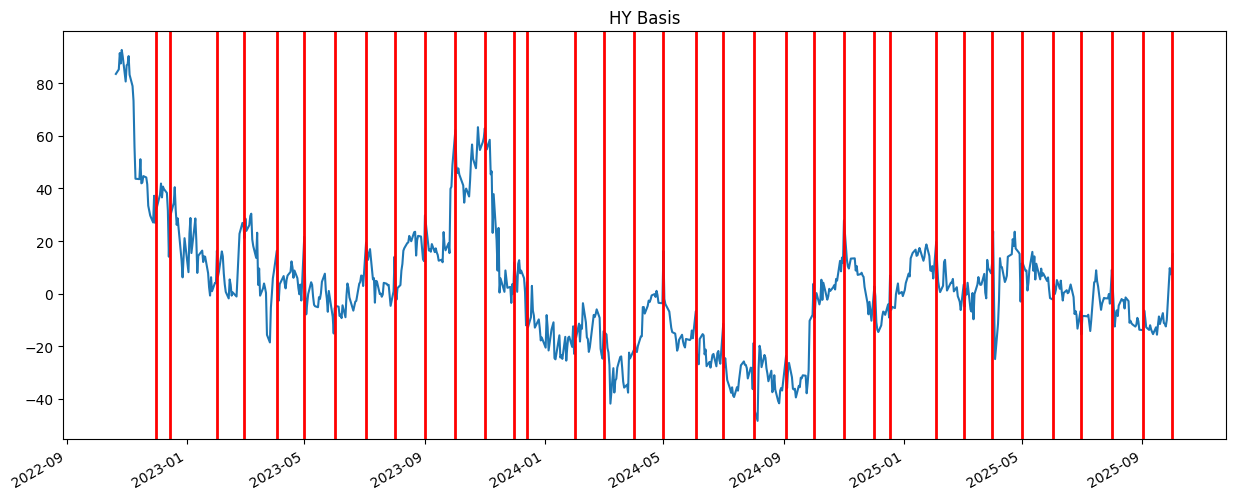

In [19]:
start_daily_list = []
dvd_daily_list = []
for key, val in dvd_dict.items():
    start_daily_list += [pd.to_datetime(val[0])]
    dvd_daily_list += [pd.to_datetime(key)]

# a = blp.bdh(tickers=["CDX HY CDSI GEN 5Y SPRD CORP","USGG5YR INDEX"], flds="PX_LAST", start_date='2019-1-1')
# a.columns = ["CDX HY 5Y","US 5Y"]
# b = blp.bdh(tickers=["HYG US EQUITY"], flds="YAS_BOND_YLD", start_date='2019-1-1')
# b.columns = ["HYG Yld"]
c = pd.concat([a,b],axis=1).sort_index().dropna().copy()
c = (c["CDX HY 5Y"] - 100*(c["HYG Yld"]-c["US 5Y"])).iloc[-245*3:].copy()
c.index = pd.to_datetime(c.index)

ax = c.plot(figsize=(15,6))
plt.title("HY Basis")

for label in dvd_daily_list[-12*3+3:]:
    plt.axvline(x=label, color='red', label=label, linewidth = 2)
plt.show()

In [35]:
all_day = None
for item in order:
    single_day = df_plot3[[item1.split(" ")[0]==item for item1 in df_plot3.index]].copy()
    single_day1 = single_day[[pd.to_datetime(item1.split(" ")[1]).time() <= pd.to_datetime("12:45:00").time() for item1 in single_day.index]]
    single_day2 = single_day[[pd.to_datetime(item1.split(" ")[1]).time() > pd.to_datetime("12:45:00").time() for item1 in single_day.index]]
    
    single_day1 = single_day1 - single_day1.iloc[0]
    single_day1 = single_day1.iloc[[-1]]
    single_day1 = single_day1.T
    single_day1.columns = ["Day_Move"]
    single_day1["Day"] = [item+" First Half"]*len(single_day1)
    
    single_day2 = single_day2 - single_day2.iloc[0]
    single_day2 = single_day2.iloc[[-1]]
    single_day2 = single_day2.T
    single_day2.columns = ["Day_Move"]
    single_day2["Day"] = [item+" Second Half"]*len(single_day2)
    single_day2
    day = pd.concat([single_day1, single_day2])
    all_day = pd.concat([all_day, day])
all_day

,Day_Move,Day
2021-04-01,2.255598,T-10 First Half
2021-05-03,0.621505,T-10 First Half
2021-06-01,-1.776055,T-10 First Half
2021-07-01,-2.192067,T-10 First Half
2021-08-02,-9.157808,T-10 First Half
...,...,...
2025-04-01,-1.904042,T+10 Second Half
2025-05-01,1.602747,T+10 Second Half
2025-06-02,3.590208,T+10 Second Half
2025-08-01,1.997827,T+10 Second Half


In [40]:
for item in order:
    dy = all_day.copy()
    dy["Day"] = dy["Day"].apply(lambda x: "DVD" if x in [item] else "Non-DVD")
    import pandas as pd
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    from statsmodels.stats.anova import anova_lm
    
    model = ols('Day_Move ~ Day', data=dy).fit()
    
    anova_results = anova_lm(model, typ=2)
    display(f"day count is {item} and ANOVA p-value is {anova_results.iloc[0,-1]:.4f}")

'day count is T-10 and ANOVA p-value is 0.7985'

'day count is T-9 and ANOVA p-value is 0.6888'

'day count is T-8 and ANOVA p-value is 0.6189'

'day count is T-7 and ANOVA p-value is 0.3666'

'day count is T-6 and ANOVA p-value is 0.3273'

'day count is T-5 and ANOVA p-value is 0.1900'

'day count is T-4 and ANOVA p-value is 0.8146'

'day count is T-3 and ANOVA p-value is 0.3852'

'day count is T-2 and ANOVA p-value is 0.4795'

'day count is T-1 and ANOVA p-value is 0.0051'

'day count is T+0 and ANOVA p-value is 0.2301'

'day count is T+1 and ANOVA p-value is 0.1988'

'day count is T+2 and ANOVA p-value is 0.9832'

'day count is T+3 and ANOVA p-value is 0.9429'

'day count is T+4 and ANOVA p-value is 0.4887'

'day count is T+5 and ANOVA p-value is 0.0357'

'day count is T+6 and ANOVA p-value is 0.7442'

'day count is T+7 and ANOVA p-value is 0.3719'

'day count is T+8 and ANOVA p-value is 0.2517'

'day count is T+9 and ANOVA p-value is 0.4193'

'day count is T+10 and ANOVA p-value is 0.5876'

In [ ]:
display(dy[dy["Day"]=="DVD"]["Day_Move"].mean())
display(dy[dy["Day"]=="Non-DVD"]["Day_Move"].mean())

In [ ]:
print(model.summary())

In [ ]:
# df_plot1.mean(axis=1)[78*2-10:78*2+20]
y=df_plot1a[78-1:78+1].T.copy()#.mean(axis=1).plot(figsize=(12,6))
y["Diff"] = y["T-2 09:30:00"] - y["T-3 15:55:00"]
y.iloc[34:40]

In [ ]:
y[abs(y["Diff"])>4]

In [ ]:
s1 = s[:78]
s1[s1==np.max(s1)]

In [ ]:
s2 = s[78:78*2]
s2[s2==np.min(s2)]

In [ ]:
1.793356+0.638569

In [ ]:
s2[s2==np.max(s2)]

In [ ]:
0.638569+0.652229